In [2]:
import numpy as np 
import statsmodels.api as sm
import pandas as pd 
import matplotlib.pyplot as plt
import distinctipy


In [3]:
fed_interest = pd.read_csv('FEDFUNDS.csv', index_col= 0)
euro_interst = pd.read_csv('INTDSREZM193N.csv', index_col = 0)


fed_interest.index = pd.to_datetime(fed_interest.index, format = "%Y-%m-%d")

fed_interest['FED FUNDS PCT CHANGE'] = fed_interest['FEDFUNDS'].diff()
fed_interest['Intercept'] = 1 

euro_interst['EURO PCT CHANGE'] = euro_interst['INTDSREZM193N'].pct_change()
euro_interst['Intercept'] = 1 

fed_interest

,FEDFUNDS,FED FUNDS PCT CHANGE,Intercept
DATE,,,
1999-01-01,4.63,NaN,1
1999-02-01,4.76,0.13,1
1999-03-01,4.81,0.05,1
1999-04-01,4.74,-0.07,1
1999-05-01,4.74,0.00,1
...,...,...,...
2017-01-01,0.65,0.11,1
2017-02-01,0.66,0.01,1
2017-03-01,0.79,0.13,1


In [4]:
dependent = fed_interest.loc["1999-02-01": , ['FED FUNDS PCT CHANGE']].reset_index()
independent = fed_interest.loc["1999-01-01" : "2017-04-01", ['FEDFUNDS', 'Intercept']].reset_index()

dependent = dependent[['FED FUNDS PCT CHANGE']]
independent = independent[['FEDFUNDS', 'Intercept']]

In [5]:
results = sm.regression.linear_model.OLS(dependent, independent)
results = results.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     FED FUNDS PCT CHANGE   R-squared:                       0.006
Model:                              OLS   Adj. R-squared:                  0.002
Method:                   Least Squares   F-statistic:                     1.356
Date:                  Sun, 20 Oct 2024   Prob (F-statistic):              0.246
Time:                          16:36:26   Log-Likelihood:                 79.063
No. Observations:                   220   AIC:                            -154.1
Df Residuals:                       218   BIC:                            -147.3
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FEDFUNDS      -0.0063      0.005     -1.164      0.246      -0.017       0.004
Intercept     -0.0046      0.016     -0.294      0.769      -0.035       0.026
==============================================================================
Omnibus:                      119.929   Durbin-Watson:                   0.594
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              696.525
Skew:                          -2.117   Prob(JB):                    5.64e-152
Kurtosis:                      10.619   Cond. No.                         4.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
srr = np.sum(results.resid **2)
sigma = np.sqrt(srr/218)
sigma

np.float64(0.1696955015428785)

In [7]:
steps_per_year=12
n_years = 5
dt = 1/steps_per_year
n_scenarios=100
n_steps = int(n_years*steps_per_year) + 1
xi = np.random.normal(loc = 0, scale = 1, size=(n_steps, n_scenarios))
xi

array([[-0.70387469, -0.74269448, -0.50620211, ...,  1.5732362 ,
         1.09881185, -1.94448297],
       [ 2.13894761, -0.63738223,  0.15578853, ..., -1.7021224 ,
        -1.43610445, -1.14082264],
       [ 0.68123749,  2.33486502,  0.99528406, ..., -0.46017874,
        -0.19454138, -1.15187176],
       ...,
       [-0.15575282,  0.48859487, -0.36524466, ...,  1.11297612,
         0.44433778,  1.14212829],
       [-1.52385394,  0.53889043,  0.23171751, ...,  2.10804674,
         0.83720719,  0.45761294],
       [-1.71229105, -0.38676508, -0.56760694, ...,  0.84787098,
        -1.20893193,  2.01106746]])

<Axes: >

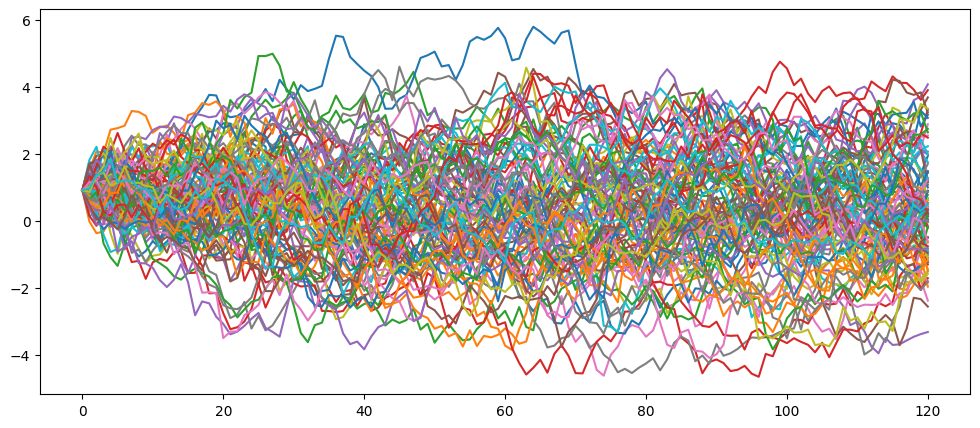

In [8]:


def Vasicek(n_years=5, n_scenarios=100, sigma=0.3941782120233022, steps_per_year=12, s_0=0.91, prices=True):
    """
    Evolution of Vasicek trajectories, such as for interest rate through OLS Regression
    :param n_years:  The number of years to generate data for
    :param n_scenarios: The number of scenarios/trajectories
    :param sigma: Annualized Volatility
    :param steps_per_year: granularity of the simulation
    :param s_0: initial value
    :return: a numpy array of n_scenarios columns and n_years*steps_per_year rows
    """
    # Derive per-step Model Parameters from User Specifications
    dt = 1 / steps_per_year
    n_steps = int(n_years * steps_per_year) + 1
    xi = np.random.normal(loc=0, scale=1, size=(n_steps, n_scenarios))
    
    # Initialize the interest rate array
    rt = np.zeros((n_steps, n_scenarios))
    rt[0] = s_0
    
    # Generate the interest rate path
    for t in range(1, n_steps):
        rt_t_minus_1 = rt[t-1]
        mu = 0.12696477992025623 - (0.36066768232360874* rt_t_minus_1)
        change = mu * dt + sigma  * xi[t]
        rt[t] = rt_t_minus_1 + change
    

    rt = pd.DataFrame(rt)
    
    return rt



simulated =  Vasicek(n_years=10, n_scenarios=100, sigma=0.3941782120233022, steps_per_year=12, s_0=fed_interest['FEDFUNDS'].iloc[-1], prices=True)
simulated.plot(figsize=(12,5), legend = False)



C:\Users\Admin\AppData\Local\Temp\ipykernel_13432\2929578840.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=fed_interest.tail(1).index[0], periods=simulated.shape[0], freq='M'),


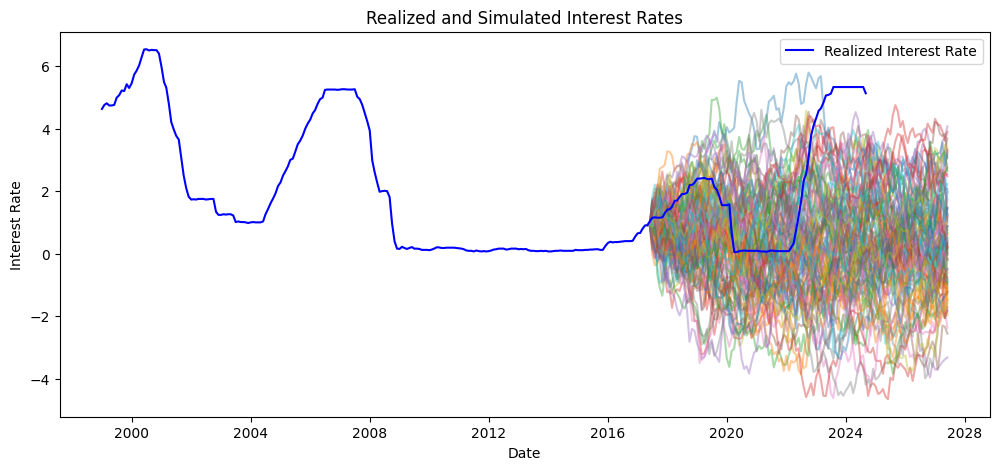

In [9]:
import matplotlib.cm as cm

# Set the figure size
plt.figure(figsize=(12, 5))

# Plot the realized interest rate with a specific color
plt.plot(fed_interest.index, fed_interest['FEDFUNDS'], label='Realized Interest Rate', color = 'Blue' )


fed_interest_2017 = pd.read_csv('FEDFUNDS2017.csv', index_col=0)
fed_interest_2017.index = pd.to_datetime(fed_interest_2017.index, format = "%Y-%m-%d")

# Plot the simulated paths
for i in range(simulated.shape[1]):
    plt.plot(pd.date_range(start=fed_interest.tail(1).index[0], periods=simulated.shape[0], freq='M'),
             simulated[i], alpha=0.4)

plt.plot(fed_interest_2017.index, fed_interest_2017['FEDFUNDS'], color = 'Blue')
# Add labels and title
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.title('Realized and Simulated Interest Rates')
plt.legend()
plt.show()

In [10]:
np.mean(simulated.iloc[-1])

np.float64(0.3633409277429822)

## CIR Model 


In [11]:
simulated2 = Vasicek(n_years=10, n_scenarios=10000, sigma=sigma, s_0=fed_interest['FEDFUNDS'].iloc[-1], prices=True)
np.mean(simulated2.iloc[-1])


np.float64(0.37745366959322607)

In [12]:
from scipy.optimize import minimize
from scipy.stats import ncx2


def cir_log_likelihood(params, r, dt):
    a, b, sigma = params
    n = len(r)
    log_likelihood = 0
    for i in range(1, n):
        rt = r[i-1]
        rt1 = r[i]
        mu = rt + a * (b - rt) * dt
        var = sigma**2 * rt * dt
        log_likelihood += -0.5 * (np.log(2 * np.pi * var) + ((rt1 - mu)**2 / var))
    return -log_likelihood

# Initial guess for parameters
initial_params = [-0.001 ,0.5 , 0.16969]
dt = 1/12

r = fed_interest['FEDFUNDS'].to_numpy()
result = minimize(cir_log_likelihood, initial_params, args=(r, dt), bounds=[(None, None), (None, None), (None, None)])
a_est, b_est, sigma_est = result.x
print(f"Estimated parameters: a={a_est}, b={b_est}, sigma={sigma_est}")

Estimated parameters: a=0.12696588189700905, b=0.3606628151560605, sigma=0.3941780533901862


In [13]:
cir_log_likelihood(initial_params, r = r, dt = 1/12)

np.float64(109.1072347051254)

In [14]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -197.98944412491986
        x: [ 1.270e-01  3.607e-01  3.942e-01]
      nit: 16
      jac: [ 1.791e-04 -2.842e-05 -4.349e-04]
     nfev: 92
     njev: 23
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

<Axes: >

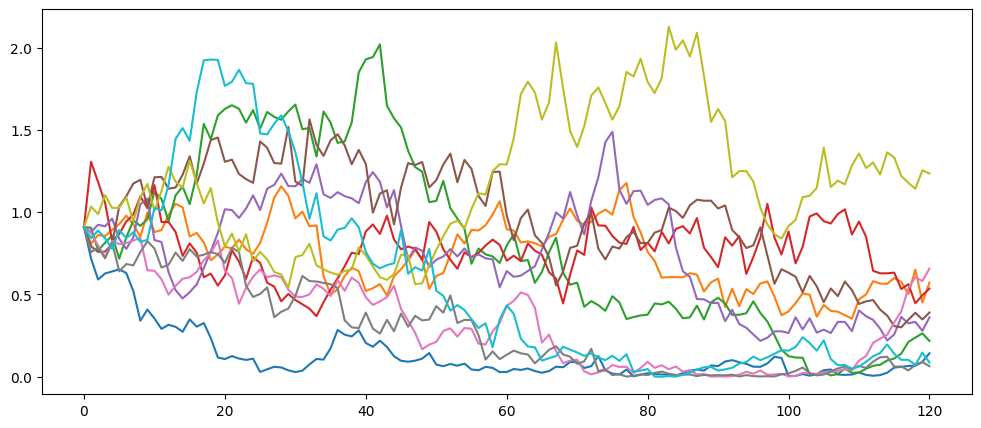

In [15]:
def cir(n_years = 10, n_scenarios=1, a=0.12696477992025623, b=0.36066768232360874, sigma=0.3941782120233022, steps_per_year=12, r_0=fed_interest['FEDFUNDS'].iloc[-1]):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b 
    r_0 = r_0
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t) # just in case of roundoff errors going negative
        
    return pd.DataFrame(data=rates, index=range(num_steps))

CIR=cir(n_scenarios=10)
CIR.plot(figsize=(12,5), legend=False)

C:\Users\Admin\AppData\Local\Temp\ipykernel_13432\162431312.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=fed_interest.tail(1).index[0], periods=CIR.shape[0], freq='M'),


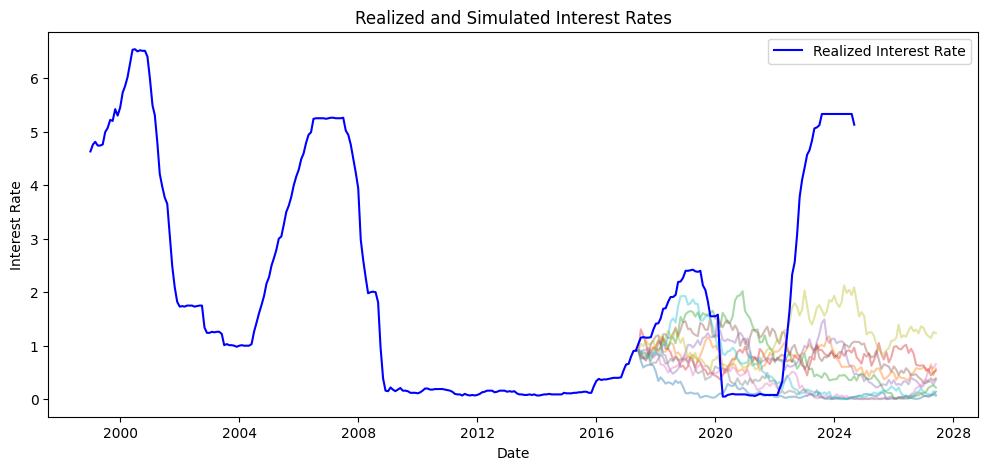

In [16]:
# Set the figure size
plt.figure(figsize=(12, 5))

# Plot the realized interest rate with a specific color
plt.plot(fed_interest.index, fed_interest['FEDFUNDS'], label='Realized Interest Rate', color = 'Blue' )


fed_interest_2017 = pd.read_csv('FEDFUNDS2017.csv', index_col=0)
fed_interest_2017.index = pd.to_datetime(fed_interest_2017.index, format = "%Y-%m-%d")

# Plot the simulated paths
for i in range(CIR.shape[1]):
    plt.plot(pd.date_range(start=fed_interest.tail(1).index[0], periods=CIR.shape[0], freq='M'),
             CIR[i], alpha=0.4)

plt.plot(fed_interest_2017.index, fed_interest_2017['FEDFUNDS'], color = 'Blue')
# Add labels and title
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.title('Realized and Simulated Interest Rates')
plt.legend()
plt.show()

In [17]:
expected = np.mean(CIR.iloc[-1])
expected

np.float64(0.4264498274039007)

In [33]:
from scipy.stats import shapiro, kstest, anderson

data = fed_interest['FEDFUNDS'].to_numpy()
# Shapiro-Wilk Test
shapiro_test = shapiro(data)
print("Shapiro-Wilk Test:", shapiro_test)

# Kolmogorov-Smirnov Test
ks_test = kstest(data, 'skewcauchy', args=(np.std(data), np.mean(data)))
print("Kolmogorov-Smirnov Test:", ks_test)

# Anderson-Darling Test
ad_test = anderson(data, dist='gumbel_l')
print("Anderson-Darling Test:", ad_test)


Shapiro-Wilk Test: ShapiroResult(statistic=np.float64(0.8062621911150408), pvalue=np.float64(7.294684941604341e-16))
Kolmogorov-Smirnov Test: KstestResult(statistic=np.float64(nan), pvalue=np.float64(nan), statistic_location=np.float64(0.07), statistic_sign=np.int8(-1))
Anderson-Darling Test: AndersonResult(statistic=np.float64(17.913206374884453), critical_values=array([0.468, 0.629, 0.747, 0.865, 1.024]), significance_level=array([25. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(3.0816107207625674), scale=np.float64(2.2375797510200797))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


In [27]:
from scipy.stats import norm, lognorm, expon, kstest
params_norm = norm.fit(data)
params_lognorm = lognorm.fit(data, floc=0)
params_expon = expon.fit(data)

ks_norm = kstest(data, 'norm', args=params_norm)
ks_lognorm = kstest(data, 'lognorm', args=params_lognorm)
ks_expon = kstest(data, 'expon', args=params_expon)

print(f"KS test for Normal: {ks_norm}")
print(f"KS test for Log-Normal: {ks_lognorm}")
print(f"KS test for Exponential: {ks_expon}")

KS test for Normal: KstestResult(statistic=np.float64(0.20631483436171344), pvalue=np.float64(9.976866473394314e-09), statistic_location=np.float64(0.41), statistic_sign=np.int8(1))
KS test for Log-Normal: KstestResult(statistic=np.float64(0.16804402815811592), pvalue=np.float64(6.3430996458892785e-06), statistic_location=np.float64(0.2), statistic_sign=np.int8(1))
KS test for Exponential: KstestResult(statistic=np.float64(0.30436789719599716), pvalue=np.float64(1.1504020896372212e-18), statistic_location=np.float64(0.2), statistic_sign=np.int8(1))


count    221.000000
mean       1.954072
std        2.119058
min        0.070000
25%        0.150000
50%        1.010000
75%        3.970000
max        6.540000
Name: FEDFUNDS, dtype: float64


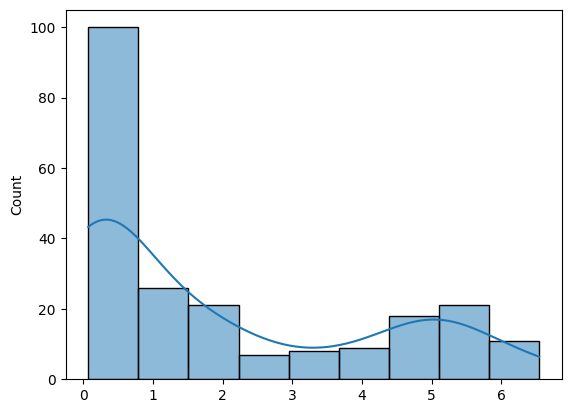

In [22]:
import seaborn as sns

sns.histplot(data, kde=True)
print(fed_interest['FEDFUNDS'].describe())


In [36]:
def cir2(n_years = 10, n_scenarios=1, a=-0.0063, b=0.730, sigma=sigma, steps_per_year=12, r_0=fed_interest['FEDFUNDS'].iloc[-1]):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b 
    r_0 = r_0
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t) # just in case of roundoff errors going negative
        
    return pd.DataFrame(data=rates, index=range(num_steps))

CIR2=cir2(n_scenarios=100)

C:\Users\Admin\AppData\Local\Temp\ipykernel_13432\3923224628.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=fed_interest.tail(1).index[0], periods=CIR2.shape[0], freq='M'),


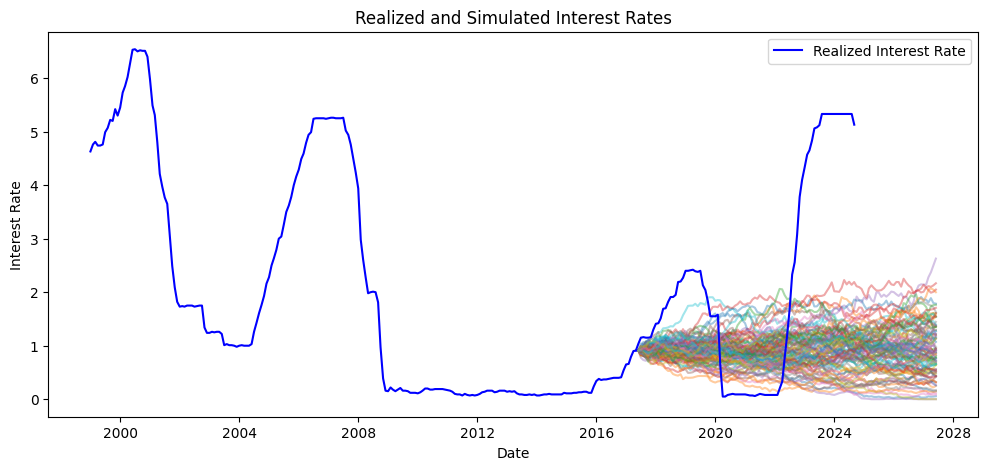

In [37]:
# Set the figure size
plt.figure(figsize=(12, 5))

# Plot the realized interest rate with a specific color
plt.plot(fed_interest.index, fed_interest['FEDFUNDS'], label='Realized Interest Rate', color = 'Blue' )


fed_interest_2017 = pd.read_csv('FEDFUNDS2017.csv', index_col=0)
fed_interest_2017.index = pd.to_datetime(fed_interest_2017.index, format = "%Y-%m-%d")

# Plot the simulated paths
for i in range(CIR2.shape[1]):
    plt.plot(pd.date_range(start=fed_interest.tail(1).index[0], periods=CIR2.shape[0], freq='M'),
             CIR2[i], alpha=0.4)

plt.plot(fed_interest_2017.index, fed_interest_2017['FEDFUNDS'], color = 'Blue')
# Add labels and title
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.title('Realized and Simulated Interest Rates')
plt.legend()
plt.show()

In [38]:
np.mean(CIR2.iloc[-1])

np.float64(0.9171104897435677)